## David Gamaliel Arcos Bravo
### Practica BoW

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn import metrics
from nltk.tokenize import TweetTokenizer
from collections import Counter

In [102]:
def get_files(PATH_TRAIN, PATH_TRAIN_LABELS):
    train, train_labels = [], []
    with open(PATH_TRAIN, 'r', encoding="utf8") as f:
        train = [ line for line in f]
    with open(PATH_TRAIN_LABELS, 'r', encoding="utf8") as f:
        train_labels = f.readlines()
    return train, train_labels

In [103]:
PATH_TRAIN = 'DatasetAgresividad/mex_train.txt'
PATH_LABELS = 'DatasetAgresividad/mex_train_labels.txt'
tr_txt, tr_y = get_files(PATH_TRAIN, PATH_LABELS)

tr_txt = np.array(tr_txt)
tr_y = np.array(tr_y)

tr_txt.shape, tr_y.shape

((5544,), (5544,))

Counter({'0\n': 3562, '1\n': 1981, '0': 1})


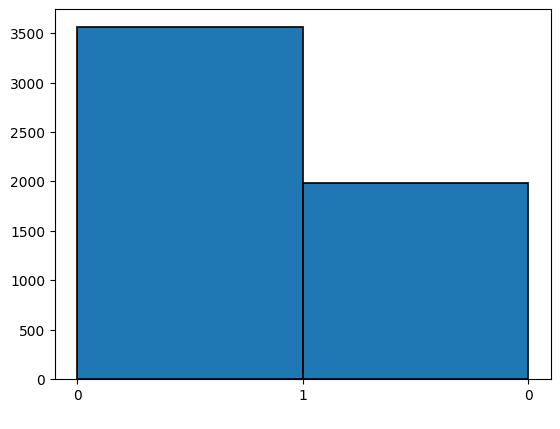

In [104]:
print(Counter(tr_y))
plt.hist(tr_y, bins=2, edgecolor='black', linewidth=1.2) # , color=['red', 'blue'])
plt.show()

In [105]:
tokenizer = TweetTokenizer()
idx = np.random.randint(0, len(tr_txt))
tr_txt[idx]
tokens = tokenizer.tokenize(tr_txt[idx])
print(tokens)

['vete', 'a', 'la', 'verga', 'skyalert', '!', '!', 'me', 'dormí', 'a', 'las', '3', 'y', 'sales', 'con', 'tus', 'putas', 'mamadas', '!', '!', '!']


In [106]:
corpus_words = []
for txt in tr_txt:
    corpus_words += tokenizer.tokenize(txt)
print(len(set(corpus_words)))

13580


In [107]:
fdist = nltk.FreqDist(corpus_words)
aux = [(fdist[key], key) for key in fdist]
aux.sort()
aux.reverse()
fdist = aux
fdist[:10]

[(3383, 'que'),
 (3357, 'de'),
 (2774, '.'),
 (2629, 'a'),
 (2433, 'la'),
 (2266, 'y'),
 (1824, 'no'),
 (1613, 'me'),
 (1505, '!'),
 (1303, 'el')]

In [108]:
idx_dict = dict()
for i, (freq, word) in enumerate(fdist):
    idx_dict[word] = i
print(idx_dict['que'])

0


In [109]:
def build_bow(tr_txt, V, idx_dict, binary=False):
    X = np.zeros((len(tr_txt), len(V)))
    for i, txt in enumerate(tr_txt):
        tokens = tokenizer.tokenize(txt)
        for token in tokens:
            if token in idx_dict:
                if binary:
                    X[i, idx_dict[token]] = 1
                else:
                    X[i, idx_dict[token]] += 1
    return X

def build_tfidf(tr_txt, V, idx_dict):
    X = build_bow(tr_txt, V, idx_dict, binary=False)
    # TF
    X = X / X.sum(axis=1, keepdims=True)
    # IDF
    df = np.zeros((len(V),))
    for i, txt in enumerate(tr_txt):
        tokens = tokenizer.tokenize(txt)
        for token in tokens:
            if token in idx_dict:
                df[idx_dict[token]] += 1
    idf = np.log(X.shape[0] / ( df + 1e-9) )
    X = X * idf
    return X

bow = build_bow(tr_txt, fdist, idx_dict)
bow.shape

(5544, 13580)

## Bolsa de validacion

Counter({'0\n': 396, '1\n': 219, '0': 1})


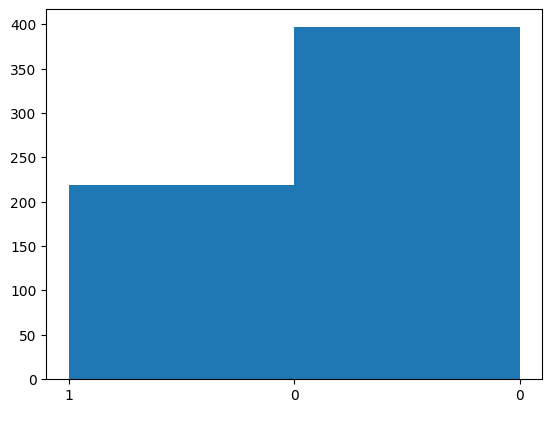

(616, 13580)

In [110]:
val_txt, val_y = get_files(
    'DatasetAgresividad/mex_val.txt',
    'DatasetAgresividad/mex_val_labels.txt'
)

val_txt = np.array(val_txt)
val_y = np.array(val_y)

print(Counter(val_y))
plt.hist(val_y, bins=len(set(val_y))-1)
plt.show()


val_bow = build_bow(val_txt, fdist, idx_dict)
val_bow.shape

# Clasificacion

In [120]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, f1_score

import warnings

In [112]:
bow_non_binary = build_bow(tr_txt, fdist, idx_dict, binary=False)
val_bow_non_binary = build_bow(val_txt, fdist, idx_dict, binary=False)

bow_binary = build_bow(tr_txt, fdist, idx_dict, binary=True)
val_bow_binary = build_bow(val_txt, fdist, idx_dict, binary=True)

tfidf = build_tfidf(tr_txt, fdist, idx_dict)
val_tfidf = build_tfidf(val_txt, fdist, idx_dict)

In [113]:
tr_y = np.array([int(y) for y in tr_y])
val_y = np.array([int(y) for y in val_y])

tr_y[:5], val_y[:5]

(array([0, 0, 0, 1, 0]), array([1, 1, 1, 0, 1]))

In [121]:
def classify(bow, tr_y, val_bow, val_y):

    parameters = {'C' : [0.05, 0.25, 1.0, 2.0]}
    svr = svm.LinearSVC(class_weight='balanced')
    grid = GridSearchCV(svr, parameters, cv=5, scoring='f1_macro')
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid.fit(bow, tr_y)
    y_pred = grid.predict(val_bow)

    p, r, f, _ = precision_recall_fscore_support(val_y, y_pred, average="macro")

    return accuracy_score(val_y, y_pred), p, r, f, y_pred

In [123]:
print("Non binary")

acc, p, r, f, non_binary_y_pred = classify(bow_non_binary, tr_y, val_bow_non_binary, val_y)
print(metrics.classification_report(val_y, non_binary_y_pred))

print("Binary")

acc, p, r, f, binary_y_pred = classify(bow_binary, tr_y, val_bow_binary, val_y)
print(metrics.classification_report(val_y, binary_y_pred))

print("TF-IDF")

acc, p, r, f, tf_idf_y_pred = classify(tfidf, tr_y, val_tfidf, val_y)
print(metrics.classification_report(val_y, tf_idf_y_pred))


Non binary
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       397
           1       0.74      0.77      0.75       219

    accuracy                           0.82       616
   macro avg       0.80      0.81      0.81       616
weighted avg       0.82      0.82      0.82       616

Binary
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       397
           1       0.73      0.77      0.75       219

    accuracy                           0.81       616
   macro avg       0.80      0.80      0.80       616
weighted avg       0.82      0.81      0.82       616

TF-IDF
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       397
           1       0.70      0.74      0.72       219

    accuracy                           0.79       616
   macro avg       0.77      0.78      0.78       616
weighted avg       0.80      0.79      0.79      

## Tweets clasificados como no agresivos que si lo eran

In [129]:
for i, (y, y_pred) in enumerate(zip(val_y, binary_y_pred)):
    if y == 1 and y_pred == 0:
        print("Tweet: ", val_txt[i])

Tweet:  así debería ser siempre para que se mueran a la verga

Tweet:  cada día me siento como un perro ovejero tratando de cuidar sus ovejas vale madre pinches rateros póngase a trabajar.😤

Tweet:  ya a cualquier prieto le dicen licenciado peludito tengan madre

Tweet:  su "pura vida" quedó en "pura verga" que se tragaron pinches ticos piojosos

Tweet:  no vayas por el mundo presumiendo tus muchos amores eso es de muy putas.

Tweet:  la que se veía súper mal era demi lovato porque se mamo con el escote y el peinado le quedo feo

Tweet:  ya traigo mi actitud de lunes al cien pinches putos.  me pelan la verga todos

Tweet:  por qué verga mis compañeros de proyecto tienen que ser los más ineptos de todos

Tweet:  una novia intelectual una putona y otra luchona. para que entre las 3 se complementen.

Tweet:  putos locos yo llevo 6 horas y aún no salgo de la segunda isla no mamen.

Tweet:  no me gusta el fútbol pero por putos &gt;:v #noerapenal

Tweet:  no  jajaja ya tiene mucho eso pero t